# Stereo Depth Perception

Depth imaging of a single opaque surface requires one additional piece
of information besides the brightness at each pixel of the image in order to produce a depth image or range image. We can distinguish four
basic principles of depth imaging known as depth from paradigms. In
addition, depth can be inferred from the slope of surfaces by a paradigm known as shape from shading.

## Principles

### Depth from Triangulation
If we observe an object from two different points of view separated by a base line b, the object will be seen under a different angle to the base line from both positions. This technique is known as triangulation and constitutes one of the basic techniques in geodesy and cartography.

In [1]:
from IPython.display import SVG, display
display(SVG('stereo_camera_setup.svg'))

$$
p = Lx_1 - rx_1 = d' \frac{X_1 + b/2}{X_3} - d' \frac{X_1 - b/2}{X_3} = b \frac{d'}{X_3}
$$

And the error has the form:

$$
\sigma_{X_3} = \frac{bd'}{p^2}\sigma_p = \frac{X_3^2}{bd'}\sigma_p
$$

Parallax is a vector quantity and parallel to the stereoscopic basis $b$. This has the advantage that if the two cameras are exactly oriented we know the direction of the parallax beforehand.

On the other hand, we cannot calculate the parallax in all cases. If an image sector does not show gray value changes in the direction of the stereo basis, then we cannot determine the parallax. This problem is a special case of the so-called aperture problem which occurs also in motion determination

### Depth from time-of-flight

A signal is sent out, propagates with a characteristic speed to the object, is reflected and travels back to the camera. The travel time is directly proportional to the sum of the distances between the sender and the object and the object and the receiver.

If the signal is sent out from the position of the camera, it has to travel twice the distance between the camera and the object reflecting the signal. Therefore the delay $\tau$ is given by:

$$
\tau = \frac{2z}{c}
$$

With an error:

$$
\sigma_z = \frac{c}{2}\sigma_\tau
$$

### Depth from phase

Interferometry can be regarded as a special form of time-of-flight distance measurement. This technique measures distances of a fraction of the wavelength of the radiation by measuring not only the amplitude (energy) of the radiation but also its phase. Phase measurements are possible by superimposition of coherent radiation leading to high intensities when the two superimposing wave fronts are in phase and to low intensities when they show a phase shift of $180°$. Light has wavelengths between $400$ and $700\ nm$. Consequently interferometric distance measurements with light resolve distances in the nanometer range ($10−9\ m$) — a small fraction of the wavelength.

![Alt Text](interferometer.gif)

$$
z = \frac{\lambda}{4\pi}\phi,\quad \sigma_z = \frac{\lambda}{4\pi} \sigma_\phi \quad \Delta z = \frac{\lambda}{2}
$$

## Depth Estimation Algorithm

<img src="rectification.png" alt="Drawing" style="width: 600px;"/>

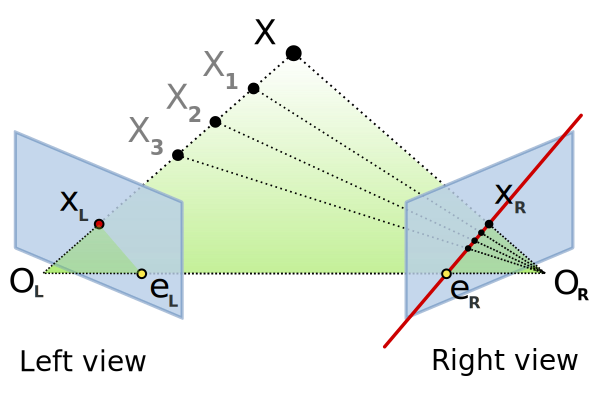

In [18]:
from IPython.display import SVG, display
display(SVG('equipolar_geometry.svg'))

Steps to get depth map:

* Identify similar points from feature descriptors.
* Match feature correspondence using a matching cost function.
* Using epipolar geometry, find and match correspondence in one picture frame to the other.
* Compute disparity from known correspondence $d = x1 — x2$.
* Compute depth from known disparity $z = (f*b)/d$



In [98]:
img1 = cv.imread('meter_l.pgm',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('meter_r.pgm',cv.IMREAD_GRAYSCALE) # trainImage

def get_matches(img1, img2, num_matches=20):
    # Initiate ORB detector
    orb = cv.ORB_create()

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[0:num_matches],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img3)
    plt.show()
    
    return kp1, kp2, matches

kp1, kp2, matches = get_matches(img1, img2)

In [99]:
def get_fundamental_matrix(kp1, kp2, matches):
    good = []
    pts1 = []
    pts2 = []

    # ratio test as per Lowe's paper
    for m in matches:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

        
    #  Now we have the list of best matches from both the images. Let's find the Fundamental Matrix. 
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)

    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    
    return pts1, pts2, F

pts1, pts2, F = get_fundamental_matrix(kp1, kp2, matches)

In [100]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

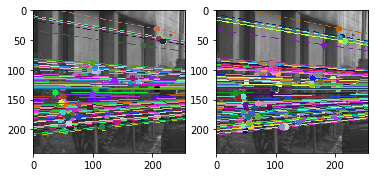

In [101]:
def draw_epilines(img1, img2, pts1, pts2, F):
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

draw_epilines(img1, img2, pts1, pts2, F)

In [102]:
ret, H1, H2 = cv.stereoRectifyUncalibrated(pts1, pts2, F, img1.shape)

warped_img1 = cv.warpPerspective(img1, H1, img1.shape)
warped_img2 = cv.warpPerspective(img2, H2, img2.shape)


plt.subplot(121),plt.imshow(warped_img1, cmap='gray')
plt.subplot(122),plt.imshow(warped_img2, cmap='gray')
plt.show()

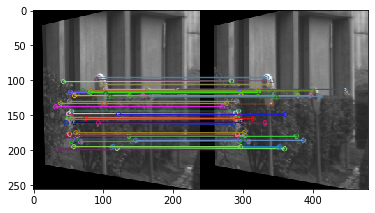

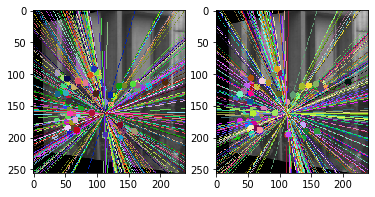

In [96]:
kp1, kp2, matches = get_matches(warped_img1, warped_img2, 50)
pts1, pts2, F = get_fundamental_matrix(kp1, kp2, matches)
draw_epilines(warped_img1, warped_img2, pts1, pts2, F)

## Disparity Map

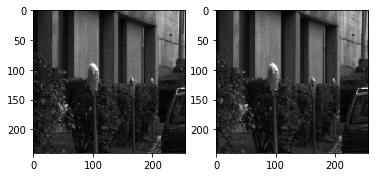

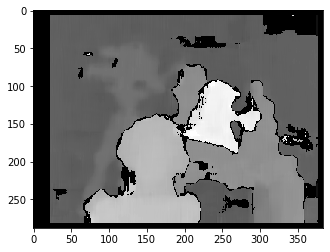

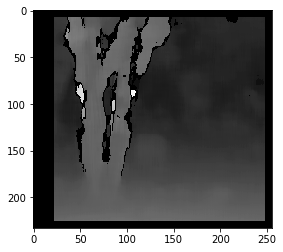

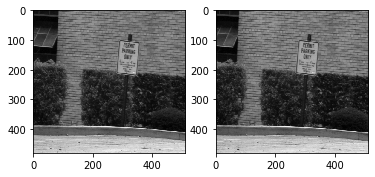

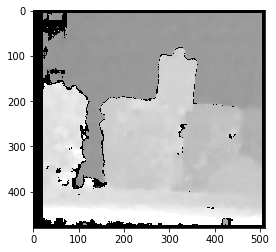

In [95]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)

imgL = cv.imread('meter_l.pgm',0)
imgR = cv.imread('meter_r.pgm',0)

plt.subplot(121),plt.imshow(imgL, cmap='gray')
plt.subplot(122),plt.imshow(imgR, cmap='gray')
plt.show()

disparity = stereo.compute(imgL, imgR)
plt.imshow(disparity,'gray')
plt.show()


imgL = cv.imread('scene_l.pgm',0)
imgR = cv.imread('scene_r.pgm',0)


plt.subplot(121),plt.imshow(imgL, cmap='gray')
plt.subplot(122),plt.imshow(imgR, cmap='gray')
plt.show()

disparity = stereo.compute(imgL, imgR)
plt.imshow(disparity,'gray')
plt.show()


imgL = cv.imread('tree_l.pgm',0)
imgR = cv.imread('tree_r.pgm',0)


plt.subplot(121),plt.imshow(imgL, cmap='gray')
plt.subplot(122),plt.imshow(imgR, cmap='gray')
plt.show()

disparity = stereo.compute(imgL, imgR)
plt.imshow(disparity,'gray')
plt.show()


imgL = cv.imread('SHRUB-03.pgm',0)
imgR = cv.imread('SHRUB-15.pgm',0)


plt.subplot(121),plt.imshow(imgL, cmap='gray')
plt.subplot(122),plt.imshow(imgR, cmap='gray')
plt.show()

disparity = stereo.compute(imgL, imgR)
plt.imshow(disparity,'gray')
plt.show()

## Stereo Calibration

<img src="stereocalibrate.png" alt="Drawing" style="width: 800px;"/>

## Real Use Case: AL6100

<img src="al6100.png" alt="Drawing" style="width: 800px;"/>

## Referencias
Jähne, B. (2002). Digital Image Processing 5th revised and extended edition. Berlin: Springer-Verlag, doi, 10, 3-540.